# Introduction to NLP: Traditional approaches
# Tokenization, Term Document Matrix, TFIDF and Text classification

In this notebook we continue to show and describe some traditional methods to address an NLP task, a text classifier.
This is an easy and quick text classifier, built based on a classical approach to NLP problems: describe the process of tokenization, how to build a Term-Document Matrix (using some methods like Counting words and TFIDF) as the numericalization method and then apply a ML classifierto predict or classify a tweet as real or fake.

Link to problem descripotion in Kaggle
Link to code: https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class/spam2.py
Link to blog post or aditional readings:
http://www.darrinbishop.com/blog/2017/10/text-analytics-document-term-matrix/
Darring Bishop



### Importing the libraries

In [1]:
# Import utility libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline
# Import libraries for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
from wordcloud import WordCloud

We set the variables for data location

In [2]:
# Global parameters
#root folder
root_folder='.'
#data_folder='.'
data_folder_name='data'
train_filename='cleaned_train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'


### Loading the datasets

This notebook does not cover how to implement the best preprocessor to clean our tweets. So we are going to feed our model with the tweet as is or only removing no alphanumeric characters. For a better results, we should inspect the tweets and apply some cleaning removing useless words, mispelling words, maybe the URIs,...  

In [3]:
#Read the tweets of our train dataset
data = pd.read_csv(train_path+'\\'+train_filename)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask . canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place ' are...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [4]:
#Extract only the text and target columns from our dataframe
data = data[[TEXT_COLUMN, TARGET_COLUMN]]
data.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask . canada,1
2,all residents asked to 'shelter in place ' are...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,just got sent this photo from ruby alaska as s...,1


## Prepare the data to be used in our model

We split the train dataset into a train and validation dataset so we can evaluate the result and apply tricks like cross-validation. This job is done as in many others notebooks, using sklearn. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[TEXT_COLUMN], data[TARGET_COLUMN].values , test_size=0.20, random_state=0)

print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)


X Train Size: (6090,)
X Test Size: (1523,)


## Creating features or numericalizing the text: Term-Document Matrix

"A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. There are various schemes for determining the value that each entry in the matrix should take. One such scheme is tf-idf. They are useful in the field of natural language processing."

We can consider a Document Term Matrix (DTM) as an implementation of the Bag of Words concept. Term Document Matrix is tracking the term frequency for each term by each document. You start with the Bag of Words representation of the documents and then for each document, you track the number of time a term exists. Term count is a common metric to  use in a Document Term Matrix  but it is not the only metric. It should be very easy to see that the DTM representation contains each distinct term from the corpus ( a collection of documents)  and the count of each distinct term in each document. A Document Term matrix can become a very large, sparse matrix (so much 0s than values) depending on the number of documents in the corpus and the number of terms in each document. We can now calculate basic statistics such as average term count, mean, median, mode, variance and standard deviation of the length of the documents. We can also tell which terms are more frequent in the collection of documents and can use that information to determine which terms more likely “represent” the document.

Considering that our data is a collections of tweets (documents) in text format the process will need to tokenize the text to get a set of tokens (items in our vocabulary), in this stage we usually reduce the number of terms o tokens, removing those that seems to be not relevant. If our vocab contains too many words, many of them not relevant, we will spend many resources and our DTM could be useless to the process.

Now it is time to convert a collection of text documents (our tweets) to a matrix of token/word counts. f you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.


## Count Vectorizer

Now it is time to convert a collection of text documents (our tweets) to a matrix of token/word counts. if you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

We simply count the times that the term is on the document and it will be the value of their corresponding cell. 

In [6]:
# Create a Counter of tokens
count_vectorizer = CountVectorizer(decode_error='ignore', lowercase=True, min_df=1)
# Apply it on the train data to get the vocabulary and the mapping. This vocab and mapping is then applied to the test set.
# Before, we convert to Unicode to avoid issues with CountVectorizer
train = count_vectorizer.fit_transform(X_train.values.astype('U'))
test = count_vectorizer.transform(X_test.values.astype('U'))


In [7]:
train.shape

(6090, 14785)

Our term-document matrix is a 6090 x 12063 matrix (this value can vary depending on text reprocessing applied), 6090 documents or tweets and a dictionary of size 12063.

Lets plot some item in the vocabulary. Now our dataset is a bunch of integer id, every one representing a word o token. This data format is teh same that a machine learning classifier woudld expect so we can apply any of them to build a model that predicts some target value we are interested in.

We need the vocaulary to translate from the integer value of a word to the corresponding word, it is created in the function or process to write the term document matrix and we can use it to "reverse" the data from numbers to text.  

In [8]:
print(count_vectorizer.vocabulary_)

lster': 1969, 'approval': 1115, 'division': 4033, 'njturnpike': 9136, 'reopens': 10868, 'blairmcdougall': 1859, 'commenting': 3014, 'dealings': 3634, 'arkan': 1162, 'asshole': 1250, 'wxia': 14591, 'senatemajldr': 11602, 'rand': 10599, 'norwaymfa': 9201, 'bahrain': 1465, 'langata': 7564, '22pm': 204, 'coloiccarnality': 2976, 'instincts': 6795, 'scratches': 11497, 'patron': 9769, 'australians': 1346, 'oceans': 9335, 'urine': 13843, 'georgous': 5589, 'demonstration': 3757, 'gaabyx': 5477, 'activist': 649, 'lunasagalle': 8030, 'synapsenkotze': 12799, 'bean': 1613, 'bastard': 1561, 'awadgolf': 1386, 'capitalist': 2428, 'voted': 14086, 'elect': 4442, 'breaking411': 2088, 'blinker': 1896, 'fleeing': 5177, 'vietnamese': 14009, 'presser': 10250, 'perforated': 9843, 'shear': 11732, 'panel': 9678, 'sfor': 11681, 'sharply': 11725, 'pyrbliss': 10476, 'frusciante': 5419, '2009': 175, 'twist': 13648, 'ov': 9581, 'typing': 13666, 'ants': 1051, 'notes': 9211, 'zotar': 14778, 'skeleton': 11940, 'alchemi

## TF-IDF
Another technique to create the DTM is the TFIDF. In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

TF-IDF is the product of two statistics, **term frequency** and **inverse document frequency**. There are various ways for determining the exact values of both statistics.

Both statistics can be computed in several ways but the most standard would be:
- term frequency adjusted for document length : $TF$ = \frac{\text{ft,d}\text{(number of words in d)}}
- IDF

In [9]:
# try multiple ways of calculating features
# Create the numericalizer TFIDF for lowercase
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True)
# Numericalize the train dataset
train = tfidf.fit_transform(X_train.values.astype('U'))
# Numericalize the test dataset
test = tfidf.transform(X_test.values.astype('U'))


## Create and train the models

### Naive Bayes

We are going to use a traditional classifier very often used in text classification: Naive Bayes using multinomial models. 
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In other notebook we will talk about Naive Bayes and Bayes rule, describing why they produce great resuls in NLP task. 

Just for comparison purposes, we will build others classifier for binary classfication to check if our model performance is good enough for this task, as an initial soluction to improve.  


In [10]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB()
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("test score:", model.score(test, y_test))

train score: 0.8811165845648604
test score: 0.7918581746552856


In [38]:
train

<6090x8601 sparse matrix of type '<class 'numpy.int64'>'
	with 54463 stored elements in Compressed Sparse Row format>

## XGBoost classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning. This is a good dataset for a first XGBoost model because all of the input variables are numeric and the problem is a simple binary classification problem.

Boosting, on the other hand, takes a more iterative approach. Rather than training all of the models in isolation of one another, boosting trains models in succession, with each new model being trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made.

In [11]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

params = {
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)

#full_clf.fit(train.astype(np.float32), y_train,verbose=1)
# Fit or train the xgboost model
full_clf.fit(train.astype(np.float32), y_train, eval_set=[(train.astype(np.float32), y_train), (test.astype(np.float32), y_test)],
             verbose=400, eval_metric=f1_metric)
# Get the predictions
Y_pred = full_clf.predict(test.astype(np.float32))
# Import libraries for predcton
from sklearn import metrics
print(metrics.classification_report(y_test, Y_pred,  digits=3),)
print(metrics.confusion_matrix(y_test, Y_pred))
#Show the results
print("train score:", full_clf.score(train.astype(np.float32), y_train))
print("test score:", full_clf.score(test.astype(np.float32), y_test))

[400]	valid_0's f1_score: 0.922718	valid_1's f1_score: 0.769477
[800]	valid_0's f1_score: 0.959127	valid_1's f1_score: 0.760538
[1200]	valid_0's f1_score: 0.972639	valid_1's f1_score: 0.753817
              precision    recall  f1-score   support

           0      0.776     0.825     0.800       886
           1      0.733     0.669     0.700       637

    accuracy                          0.760      1523
   macro avg      0.755     0.747     0.750      1523
weighted avg      0.758     0.760     0.758      1523

[[731 155]
 [211 426]]
train score: 0.9781609195402299
test score: 0.7596848325673013


Now, we can predict on the test dataset to get the results and compare with others methods.

In [12]:
Y_pred = full_clf.predict(test.astype(np.float32))

from sklearn import metrics
print(metrics.classification_report(y_test, Y_pred,  digits=3),)
print(metrics.confusion_matrix(y_test, Y_pred))


precision    recall  f1-score   support

           0      0.776     0.825     0.800       886
           1      0.733     0.669     0.700       637

    accuracy                          0.760      1523
   macro avg      0.755     0.747     0.750      1523
weighted avg      0.758     0.760     0.758      1523

[[731 155]
 [211 426]]


## Suport Vector Machine Classifier
### What is Support Vector Machines?

*The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.*

In a binary classification problem, to separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier.

We can use SVM algorithm to predict if a tweet is fake or real, it is just a binary classifcation problem. 

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
# Define the parameters to tune
parameters = { 
    'gamma': [0.7, 1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=4, n_jobs=-1).fit(train, y_train)


## Evaluating the model

After the model is trained, we evaluate our model on the test dataset

In [14]:
# Predicting the Test set results
y_pred = model.predict(test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
# Extract the confussion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: ',cm)
# Calculate the accuracy
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ',acc)
print('F1 score: ',f1_score(y_test, y_pred))
# Calculate the points in the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
roc_auc= auc(fpr,tpr)

Confusion Matrix:  [[810  76]
 [210 427]]
Accuracy:  0.8122127380170716
F1 score:  0.7491228070175439


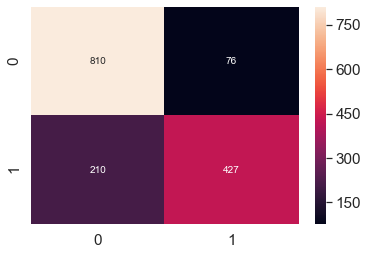

In [15]:
import seaborn as sn
# Create a dataframe with the confussion matrix values
df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
#plt.figure(figsize = (10,7))
# Plot the confussion matrix
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size

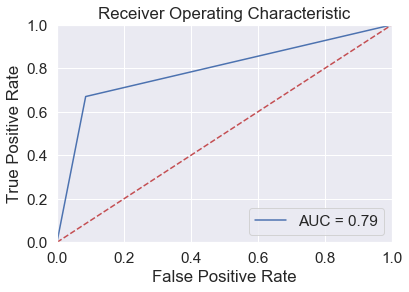

In [16]:
# ROC Curve
# plot no skill
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [34]:
y_pred.shape

(1523,)

## Visualize some results from our text

Another tool we can use to analyze the results is a WordCloud where we can draw the most relevant words in the fake tweets and real tweets. 

In [17]:
# visualize the data on a WordCloud
def visualize(label):
  words = ''
  for msg in data[data[TARGET_COLUMN] == label][TEXT_COLUMN]:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=600).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

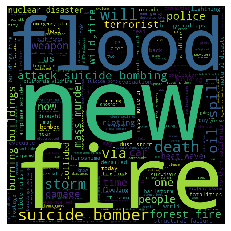

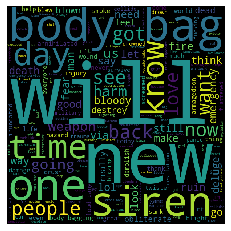

In [18]:
visualize(1)
visualize(0)

### Links:

https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47